Copyright (c) <2022>, <Regina Nockerts>
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

__NOTE__ to the user: In first use, this notebook cannot be run top to bottom. It assumes that you have a bunch of csv files that are created at different points in the notebook.

In [1]:
import pandas as pd
import numpy as np
from nlpUtils import aardvark as aa 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

In [2]:
import importlib
importlib.reload(aa)

<module 'nlpUtils.aardvark' from 'c:\\Users\\rnocker\\Desktop\\python\\thesisAgain\\nlpUtils\\aardvark.py'>

### NOTE
For VADER, I will have to create a dictionary of these codes as "words" that can be added to the lexicon.
* keep the scores from the emosent library as the prioirity
* Use the VADER score as a backup
* Manually check the results to make sure they are reasonable and identify ones to customize.

## _____________ FUNCTIONS ____________

In [3]:
# create the sentiment intensity dictionary object
# sid = SentimentIntensityAnalyzer()  #NOTE: this NEEDS to stay outside of the functions. I will be modifying it.

# FROM aardvark
# creates the sentiment intensity dictionary: aa.vader_sid(tweet)
# gets the compound score: aa.vader_sent_compound(tweet)
# gets the classification of the compund score using the authors' suggested cutoff points: aa.vader_pred(tweet, pos_cut, neg_cut)


# Setup
Assumes that you have completed dataCleaningB and dataSplitBalance

In [4]:
# Import the files that result from dataSplitBalance

unbal_x_train = pd.read_csv("dataBalancedSets/unbal_x_train.csv", header=0, index_col=0)
unbal_x_val = pd.read_csv("dataBalancedSets/unbal_x_val.csv", header=0, index_col=0)
unbal_y_train = pd.read_csv("dataBalancedSets/unbal_y_train.csv", header=0, index_col=0)
unbal_y_val = pd.read_csv("dataBalancedSets/unbal_y_val.csv", header=0, index_col=0)

# And the test dataset
x_test = pd.read_csv("dataBalancedSets/x_test.csv", header=0, index_col=0)
y_test = pd.read_csv("dataBalancedSets/y_test_sent.csv", header=0, index_col=0)

print("Unbalanced:")
print("x-train:", unbal_x_train.shape, "x-val:", unbal_x_val.shape, "y-train:", unbal_y_train.shape, "y-val:", unbal_y_val.shape)
print("TEST DATA")
print("x-TEST:", x_test.shape, "y-TEST:", y_test.shape)


Unbalanced:
x-train: (823, 3) x-val: (206, 3) y-train: (823, 5) y-val: (206, 5)
TEST DATA
x-TEST: (182, 3) y-TEST: (182, 5)


In [5]:
print(list(unbal_x_train.columns))
print(list(unbal_y_train.columns))

['id_stable', 'Date', 'ContentClean']
['id_stable', 'label_sent', 'y_sent', 'label_stance', 'y_stance']


# VADER Out of the Box
No data celaning specific to VADER / Sentiment analysis. No tuning of VADER's tools. No fancy emojis (only keyboard).

VADER is case sensitive and punctuation sensitive.

First create a new variable for the VADER predictions. Then run the function.

In [6]:
# Get the VADER compund score as a list
x_compound_VADERbase = list(x_test["ContentClean"].apply(aa.vader_sent_compound))

# Get the VADER base prediction
y_pred_VADERbase = x_test["ContentClean"].apply(aa.vader_pred)  #tweet, pos_cut = 0.05, neg_cut = -0.05

In [7]:
# First look at how the split compares to the ground truth.
print("Ground Truth:")
print(y_test["y_sent"].value_counts())
print("Pred:")
print(y_pred_VADERbase.value_counts())

Ground Truth:
0    110
1     38
2     34
Name: y_sent, dtype: int64
Pred:
0    78
2    74
1    30
Name: ContentClean, dtype: int64


Not a great first impression.

Note that I'm 
* Underpredicting 0 / negative
* Slightly underpredicting 1 / neutral
* Overpredicting 2 / positive

### Score: VADER-base, untuned

In [8]:
y_test.head()

,id_stable,label_sent,y_sent,label_stance,y_stance
1146,99980,neutral,1,neutral,1
866,131423,neutral,1,neutral,1
780,136483,fear,0,neutral,1
370,13610,disgust,0,na,1
189,36057,hopeful,2,agree,2


VADER-base prediction F-score, macro average: 0.571

              precision    recall  f1-score   support

           0       0.88      0.63      0.73       110
           1       0.50      0.39      0.44        38
           2       0.39      0.85      0.54        34

    accuracy                           0.62       182
   macro avg       0.59      0.62      0.57       182
weighted avg       0.71      0.62      0.64       182

Confusion matrix:
 [[69 11 30]
 [ 8 15 15]
 [ 1  4 29]]

Per-Class Confusion matrix:
 [[[ 63   9]
  [ 41  69]]

 [[129  15]
  [ 23  15]]

 [[103  45]
  [  5  29]]]


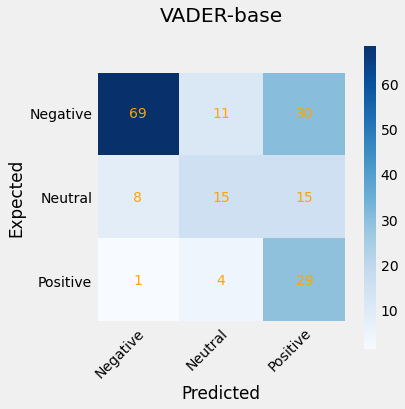

In [9]:
# Get the ground truth as a list
y_true_test = list(y_test["y_sent"])

# Get the prediction list
y_pred_VADERbase = list(y_pred_VADERbase)

# Get the metrics
aa.print_model_metrics (model_name = "VADER-base", y_true=y_true_test, y_pred=y_pred_VADERbase, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-base", y_true=y_true_test, y_pred=y_pred_VADERbase, labels=[0,1,2])

Let's try to think about what that means.

In [10]:
# Create the df with compound score, prediction, and ground truth labels
vaderBase_df = pd.DataFrame()
vaderBase_df['x_compound_VADERbase'] = x_compound_VADERbase
vaderBase_df['y_pred_VADERbase'] = y_pred_VADERbase
vaderBase_df['y_true_test'] = y_true_test

print(vaderBase_df.shape)
vaderBase_df.head()

(182, 3)


,x_compound_VADERbase,y_pred_VADERbase,y_true_test
0,0.7579,2,1
1,0.0000,1,1
2,-0.6988,0,0
3,0.3290,2,0
4,0.2960,2,2


In [11]:
vaderBase_df.groupby('y_true_test')['x_compound_VADERbase'].describe()

,count,mean,std,min,25%,50%,75%,max
y_true_test,,,,,,,,
0,110.0,-0.226029,0.552149,-0.9559,-0.70030,-0.34000,0.225775,0.8919
1,38.0,0.065600,0.351207,-0.7469,0.00000,0.00000,0.306950,0.7579
2,34.0,0.491376,0.357922,-0.6908,0.32365,0.49365,0.833775,0.9246


So, the average VADER compound score, per class, is:
* 0: negative: -0.2260
  * true negatives have an avaerage VADER score of -0.2260; seems reasonable to high
  * sd is very wide, 0.55, for a span of -1 to 1
  * there are some true negatives that score very high: 0.8919
* 1: neutral: 0.0656
  * in general, the model is scoring them too high (cutoff is 0.05/-0.05)
  * there are some true neutrals that score high: 0.7579
  * there are some true neutrals that score low: -0.7469
* 2: positive: 0.4914 
  * true positives have an avaerage VADER score of 0.4914; seems reasonable to high
  * there are some true positives that score low: -0.6908

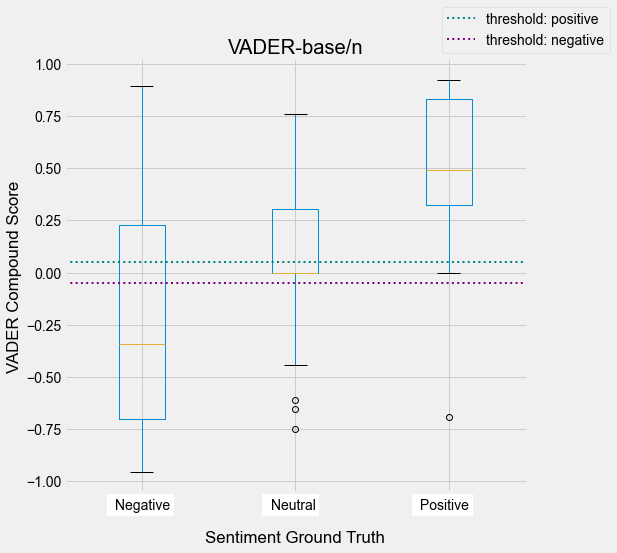

In [12]:
#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
aa.boxplot_results(model_name="VADER-base", df=vaderBase_df, score_col='x_compound_VADERbase', y_true_col="y_true_test", pos_threshold=0.05, neg_threshold=-0.05)

So, the bulk (50% boxes) of the positives and negatives are separated, but the neutral is not well separated at all. 

And the negative (class 0) is spanning a LOT of ground, while the positive (class 2) has a clear outlier.

We need more separation before we can choose good threshhold values. Though I imagine we could do a bit better even now, just by choosing 0 and 0.27-ish as our thresholds.

In [13]:
# Save the VADER-base predictions dataframe to csv
vaderBase_df.to_csv("dataVader/vaderBasePreds_df.csv")

### ---> Go to vaderPrep